# Basics

to start, let's import a few things we'll need:

In [1]:
# other package imports
import matplotlib.pyplot as plt # keep this import for CI to work
from zanj import ZANJ # saving/loading data
from muutils.mlutils import pprint_summary # pretty printing as json

# maze_dataset imports
from maze_dataset import LatticeMaze, SolvedMaze, MazeDataset, MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators, GENERATORS_MAP
from maze_dataset.generation.default_generators import DEFAULT_GENERATORS
from maze_dataset.dataset.configs import MAZE_DATASET_CONFIGS
from maze_dataset.plotting import plot_dataset_mazes, print_dataset_mazes

# check the configs
print(MAZE_DATASET_CONFIGS.keys())
# for saving/loading things
LOCAL_DATA_PATH: str = "../data/maze_dataset/"
zanj: ZANJ = ZANJ(external_list_threshold=256)

dict_keys(['test-g3-n5-a_dfs-h75556', 'demo_small-g3-n100-a_dfs-h88371', 'demo-g6-n10K-a_dfs-h30615'])


You should always see `test-g3-n5-a_dfs-h9136` in the list of available dataset configs above.

Now, let's set up our initial config and dataset:

In [2]:
cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test", # name is only for you to keep track of things
	grid_n=5, # number of rows/columns in the lattice
	n_mazes=4, # number of mazes to generate
	maze_ctor=LatticeMazeGenerators.gen_dfs, # algorithm to generate the maze
    # there are a few more arguments here, to be discussed later
)

# each config will use this function to get the name of the dataset
# it contains some basic info about the algorithm, size, and number of mazes
# at the end after "h" is a stable hash of the config to avoid collisions
print(cfg.to_fname())

test-g5-n4-a_dfs-h84708


In [3]:
# to create a dataset, just call MazeDataset.from_config
dataset: MazeDataset = MazeDataset.from_config(
    # your config
	cfg,
    # and all this below is completely optional
	do_download=False,
	load_local=False,
	do_generate=True,
    save_local=True,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False, # parallel generation has overhead, not worth it unless you're doing a lot of mazes
)

trying to get the dataset 'test-g5-n4-a_dfs-h84708'
generating dataset...


generating & solving mazes: 100%|██████████| 4/4 [00:00<00:00, 181.81maze/s]

saving dataset to ..\data\maze_dataset\test-g5-n4-a_dfs-h84708.zanj


Got dataset test with 4 items. output.cfg.to_fname() = 'test-g5-n4-a_dfs-h84708'


now that we have our dataset, let's take a look at it!

(<Figure size 400x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

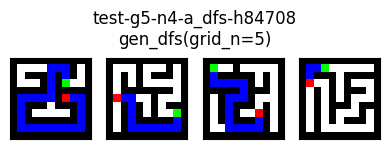

In [4]:
plot_dataset_mazes(dataset, count=None) # for large datasets, set the count to some int to just plot the first few

# Filtering

you can also filter datasets by a variety of parameters:

In [5]:
dataset_filtered: MazeDataset = dataset.filter_by.path_length(min_length=3)

print(f"{len(dataset) = }")
print(f"{len(dataset_filtered) = }")

len(dataset) = 4
len(dataset_filtered) = 4


(<Figure size 400x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

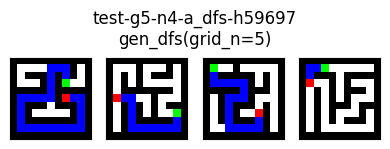

In [6]:
plot_dataset_mazes(dataset_filtered)

In [7]:
pprint_summary(dataset_filtered.cfg.serialize()["applied_filters"])
print(f"{MazeDataset._FILTER_NAMESPACE = }")

[
  {
    "name": "path_length",
    "args": [],
    "kwargs": {
      "min_length": 3
    }
  }
]
MazeDataset._FILTER_NAMESPACE = <class 'maze_dataset.dataset.maze_dataset.MazeDatasetFilters'>


In [8]:
# filters can also be specified at generation time -- but it will still generate the whole dataset and then filter it

dataset_filtered_from_scratch: MazeDataset = MazeDataset.from_config(
	dataset_filtered.cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=False,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False,
)

trying to get the dataset 'test-g5-n4-a_dfs-h59697'
generating dataset...


generating & solving mazes: 100%|██████████| 4/4 [00:00<00:00, 233.23maze/s]

Got dataset test with 4 items. output.cfg.to_fname() = 'test-g5-n4-a_dfs-h59697'


(<Figure size 400x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

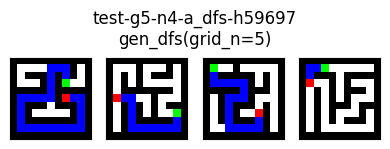

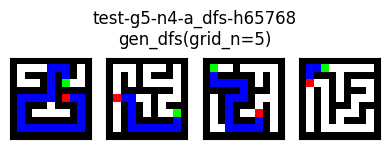

In [9]:
plot_dataset_mazes(dataset_filtered_from_scratch)
dataset_filtered_nodupe = dataset_filtered_from_scratch.filter_by.remove_duplicates()
plot_dataset_mazes(dataset_filtered_nodupe)


No mazes to plot for dataset


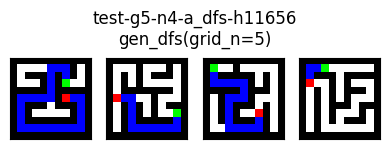

In [10]:
dataset_filtered_custom: MazeDataset = dataset.custom_maze_filter(
	lambda m, p: len(m.solution) == p,
	p=5,
)
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered_custom)

## metadata

by default, each maze stores some metadata about generation in a dictionary. if you don't care about this, you can filter it out (but keep some statistics) to save on storage space:

In [11]:
dataset_with_meta = dataset.filter_by.collect_generation_meta()
metadata = dataset_with_meta.serialize()['generation_metadata_collected']
metadata["visited_cells"] = "..." # this is a huge list and unweildy to print
pprint_summary(metadata)

{
  "func_name": {
    "gen_dfs": 4
  },
  "grid_shape": {
    "(5, 5)": 4
  },
  "start_coord": {
    "(2, 3)": 1,
    "(0, 3)": 1,
    "(0, 1)": 1,
    "(1, 3)": 1
  },
  "n_accessible_cells": {
    "25": 4
  },
  "max_tree_depth": {
    "50": 4
  },
  "fully_connected": {
    "True": 4
  },
  "visited_cells": "..."
}


# output formats

ASCII:

###########
#    XXX# #
# ###X#X# #
#   #X#S  #
#####X#####
#XXXXX#EXX#
#X### ###X#
#X#     #X#
#X#######X#
#XXXXXXXXX#
###########

Raw tokens:

<ADJLIST_START> (0,0) <--> (1,0) ; (2,0) <--> (3,0) ; (4,1) <--> (4,0) ; (2,0) <--> (2,1) ; (1,0) <--> (1,1) ; (3,4) <--> (2,4) ; (4,2) <--> (4,3) ; (0,0) <--> (0,1) ; (0,3) <--> (0,2) ; (4,4) <--> (3,4) ; (4,3) <--> (4,4) ; (4,1) <--> (4,2) ; (2,1) <--> (2,2) ; (1,4) <--> (0,4) ; (1,2) <--> (0,2) ; (2,4) <--> (2,3) ; (4,0) <--> (3,0) ; (2,2) <--> (3,2) ; (1,2) <--> (2,2) ; (1,3) <--> (0,3) ; (3,2) <--> (3,3) ; (0,2) <--> (0,1) ; (3,1) <--> (3,2) ; (1,3) <--> (1,4) ; <ADJLIST_END> <ORIGIN_START> (1,3) <ORIGIN_END> <TARGET_START> (2,3) <TARGET_END> <PATH_START> (1,3) (0,3) (0,2) (1,2) (2,2) (2,1) (2,0) (3,0) (4,0) (4,1) (4,2) (4,3) (4,4) (3,4) (2,4) (2,3) <PATH_END>

Colored tokens, raw html:

<span style="color: black; background-color: rgb(234,209,220)">&nbsp&lt;ADJLIST_START&gt; (0,0) &lt;--&gt; (1,0) ; (2,0) &lt;--&gt; (3,0) ; (4,1

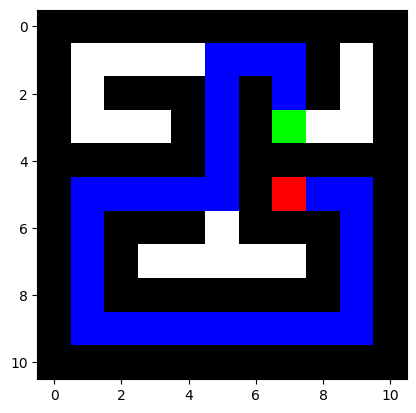

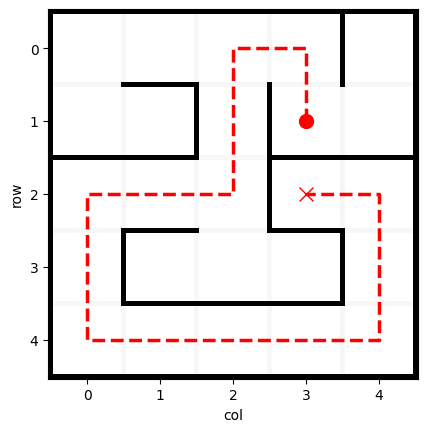

In [12]:

from maze_dataset.plotting import MazePlot
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode, MazeTokenizerModular
from maze_dataset.plotting.print_tokens import display_color_maze_tokens_AOTP, color_maze_tokens_AOTP

maze: SolvedMaze = dataset[0]

# as pixels (what you've already seen)
plt.imshow(maze.as_pixels())

# as ascii (useful for debugging)
print("ASCII:\n")
print(maze.as_ascii())

# as a MazePlot
MazePlot(maze).plot()

# as tokens

# first, initialize a tokenizer -- more about this in the `notebooks/demo_tokenization.ipynb` notebook
tokenizer: MazeTokenizerModular = MazeTokenizerModular()
maze_tok = maze.as_tokens(maze_tokenizer=tokenizer)

# you can view the tokens directly
print("\nRaw tokens:\n")
print(" ".join(maze_tok))

# or color and print them in various formats
print("\nColored tokens, raw html:\n")
print(color_maze_tokens_AOTP(maze_tok, fmt="html"))
print("\nColored tokens, raw latex:\n")
print(color_maze_tokens_AOTP(maze_tok, fmt="latex"))
print("\nColored tokens, terminal:\n")
print(color_maze_tokens_AOTP(maze_tok, fmt="terminal"))

display_color_maze_tokens_AOTP(maze_tok)

# more algorithms

there are a bunch of algorithms included, some with various parameters. Here's a few:

In [13]:
DATASETS: dict[int, list[MazeDataset]] = dict()
for grid_n in [4]:
	DATASETS[grid_n] = list()
	for gen_name, gen_kwargs in DEFAULT_GENERATORS:
		print(f"Generating {gen_name} for grid_n={grid_n}")
		DATASETS[grid_n].append(MazeDataset.from_config(
			MazeDatasetConfig(
				name="demo",
				maze_ctor=GENERATORS_MAP[gen_name],
				grid_n=grid_n,
				n_mazes=4,
				maze_ctor_kwargs=gen_kwargs,
			),
			local_base_path=LOCAL_DATA_PATH,
			load_local=False,
			verbose=False,
			zanj=zanj,
		))


Generating gen_dfs for grid_n=4
Generating gen_dfs for grid_n=4
Generating gen_dfs for grid_n=4
Generating gen_dfs for grid_n=4
Generating gen_wilson for grid_n=4
Generating gen_percolation for grid_n=4
Generating gen_dfs_percolation for grid_n=4
Generating gen_dfs_percolation for grid_n=4


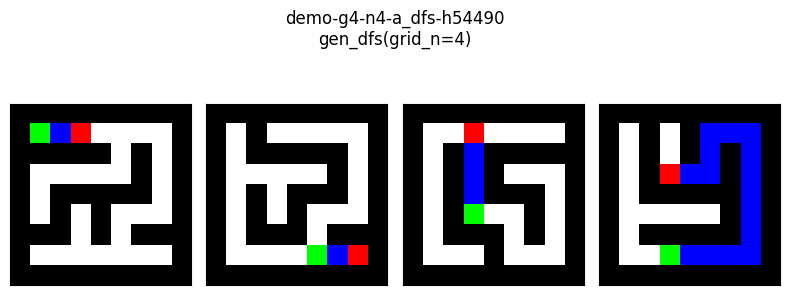

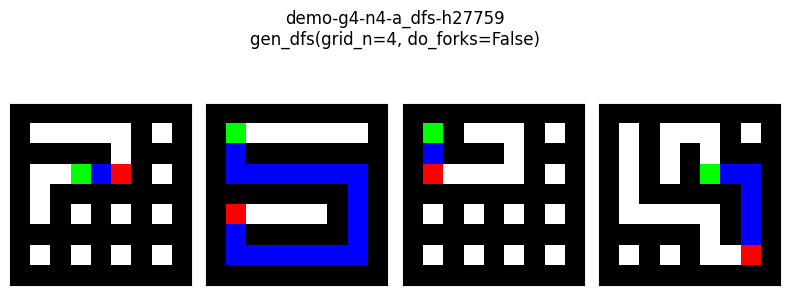

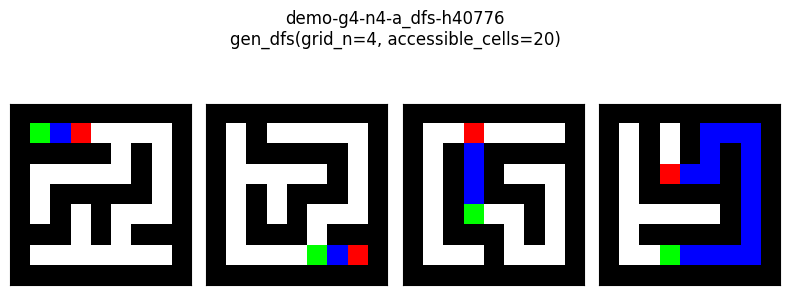

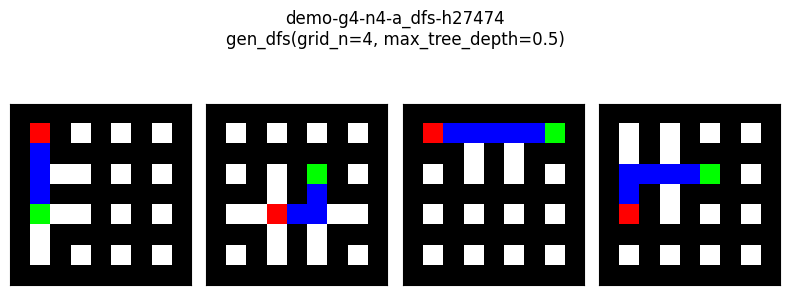

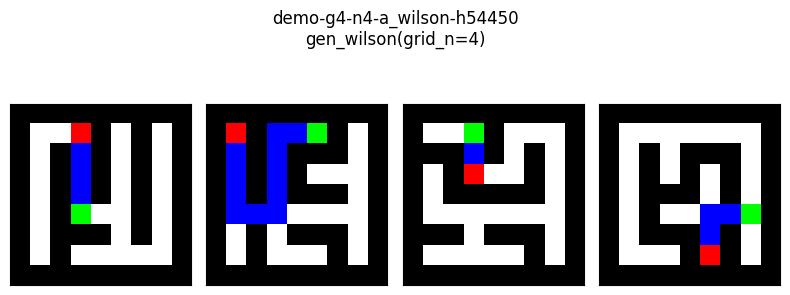

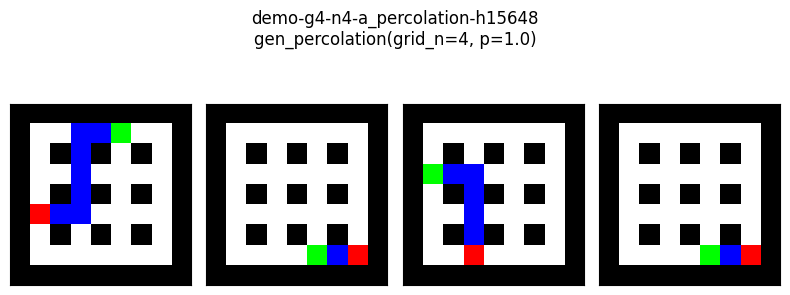

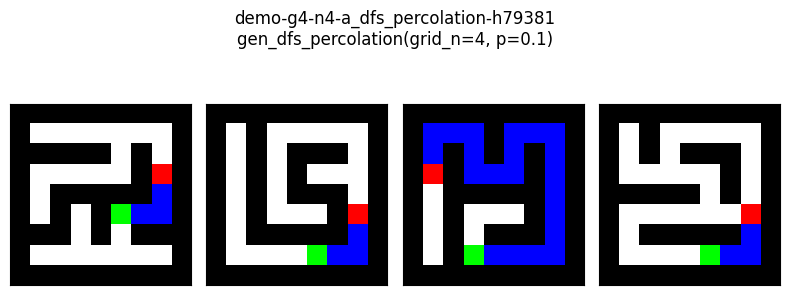

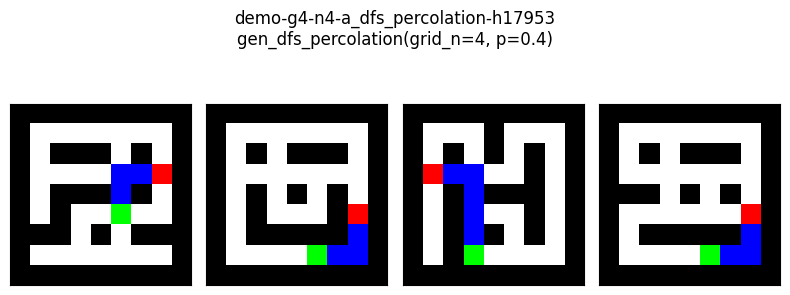

In [14]:
for g, ds_list in DATASETS.items():
    for ds in ds_list:
        plot_dataset_mazes(ds, figsize_mult=(2, 4))
